<a href="https://colab.research.google.com/github/ilhamdwiprastyo/Sentiment-Analysis-with-XLNet-Model/blob/main/XLNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers
!pip install sentencepiece

     |████████████████████████████████| 2.5MB 13.7MB/s 
     |████████████████████████████████| 901kB 35.9MB/s 
     |████████████████████████████████| 3.3MB 49.6MB/s 
     |████████████████████████████████| 1.2MB 14.8MB/s 


In [ ]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1H4o_iaTuTKhBJkr8fSpGvBWJK1kKApxL

Downloading...
From: https://drive.google.com/uc?id=1H4o_iaTuTKhBJkr8fSpGvBWJK1kKApxL
To: /content/Clean_Dataset_TripAdvisor.zip
23.1MB [00:00, 30.2MB/s]


In [ ]:
!unzip /content/Clean_Dataset_TripAdvisor.zip

Archive:  /content/Clean_Dataset_TripAdvisor.zip
  inflating: Clean_Dataset_TripAdvisor.csv  


In [ ]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from collections import defaultdict
from textwrap import wrap
from pylab import rcParams

from torch import nn, optim
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset,RandomSampler,SequentialSampler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [ ]:
df = pd.read_csv('Clean_Dataset_TripAdvisor.csv')
df.head()

,Review_Text,text bersih,text bersih banget,text bersih poll banget,Rating
0,Saya menginap di Alila seminyak selama 3 malam...,saya menginap di alila seminyak selama malam s...,menginap alila seminyak malam menginap kamar d...,inap alila minyak malam inap kamar lantai lobb...,5
1,"Bagian terbaik, saya bisa membuka seluruh jend...",bagian terbaik saya bisa membuka seluruh jende...,terbaik membuka jendela menghadap laut menikma...,baik buka jendela hadap laut nikmat debur omba...,5
2,"Dalam keadaan pandemi seperti ini,performa Hot...",dalam keadaan pandemi seperti ini performa hot...,pandemi performa memuaskan segi kebersihan pel...,pandemi performa muas segi bersih layan fasili...,5
3,Lokasi hotel persis di pinggir pantai dan bisa...,lokasi hotel persis di pinggir pantai dan bisa...,lokasi persis pinggir pantai menikmati sunset ...,lokasi persis pinggir pantai nikmat sunset kam...,5
4,View sunsetnya bagus! Makanannya enak dan pela...,view sunsetnya bagus makanannya enak dan pelay...,view sunsetnya bagus makanannya enak pelayanan...,view sunsetnya bagus makan enak layan server t...,5


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
df=df.drop_duplicates(subset="text bersih poll banget")
df=df.dropna()
df=df.reset_index(drop=True)
df

,Review_Text,text bersih,text bersih banget,text bersih poll banget,Rating
0,Saya menginap di Alila seminyak selama 3 malam...,saya menginap di alila seminyak selama malam s...,menginap alila seminyak malam menginap kamar d...,inap alila minyak malam inap kamar lantai lobb...,5
1,"Bagian terbaik, saya bisa membuka seluruh jend...",bagian terbaik saya bisa membuka seluruh jende...,terbaik membuka jendela menghadap laut menikma...,baik buka jendela hadap laut nikmat debur omba...,5
2,"Dalam keadaan pandemi seperti ini,performa Hot...",dalam keadaan pandemi seperti ini performa hot...,pandemi performa memuaskan segi kebersihan pel...,pandemi performa muas segi bersih layan fasili...,5
3,Lokasi hotel persis di pinggir pantai dan bisa...,lokasi hotel persis di pinggir pantai dan bisa...,lokasi persis pinggir pantai menikmati sunset ...,lokasi persis pinggir pantai nikmat sunset kam...,5
4,View sunsetnya bagus! Makanannya enak dan pela...,view sunsetnya bagus makanannya enak dan pelay...,view sunsetnya bagus makanannya enak pelayanan...,view sunsetnya bagus makan enak layan server t...,5
...,...,...,...,...,...
86491,Membaca dari agoda untuk menyediakan informasi...,membaca dari agoda untuk menyediakan informasi...,membaca agoda menyediakan informasi check in m...,baca agoda sedia informasi check in rencana ku...,1
86492,Kami mengunjungi u pasha dengan keluarga kami ...,kami mengunjungi u pasha dengan keluarga kami ...,mengunjungi u pasha keluarga kecewa fasilitas ...,unjung u pasha keluarga kecewa fasilitas layan...,1
86493,Kami pergi ke seminyak pada bulan madu kami di...,kami pergi ke seminyak pada bulan madu kami di...,pergi seminyak madu tidak layak bintang sulit ...,pergi minyak madu tidak layak bintang sulit pe...,2
86494,pertama-tama kamar teman saya adalah besar dan...,pertama tama kamar teman saya adalah besar dan...,tama kamar teman indah kesalahan keluhan memil...,tama kamar teman indah salah keluh milik sarap...,2


In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return None
  else: 
    return 1

df['sentiment'] = df.Rating.apply(to_sentiment)
df=df.dropna()
df=df.reset_index(drop=True)

In [ ]:
class_names = ['negative', 'positive']

In [ ]:
from transformers import XLNetTokenizer, XLNetModel
# PRE_TRAINED_MODEL_NAME = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained('huseinzol05/xlnet-base-bahasa-cased', do_lower_case = False)

In [ ]:
MAX_LEN = 100

In [ ]:
class ImdbDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        truncation = True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding="max_length",
        return_attention_mask=True,
        return_tensors='pt',
        )

        input_ids = pad_sequences(encoding['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        input_ids = input_ids.astype(dtype = 'int64')
        input_ids = torch.tensor(input_ids) 

        attention_mask = pad_sequences(encoding['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
        attention_mask = attention_mask.astype(dtype = 'int64')
        attention_mask = torch.tensor(attention_mask)       

        return {
        'review_text': review,
        'input_ids': input_ids.flatten(),
        'attention_mask': attention_mask.flatten(),
        'targets': torch.tensor(target, dtype=torch.long)
        }

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((56747, 6), (12160, 6), (12161, 6))

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = ImdbDataset(
    reviews=df['text bersih poll banget'].to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    # num_workers=4
  )

In [ ]:
BATCH_SIZE = 32

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
from transformers import XLNetForSequenceClassification
model = XLNetForSequenceClassification.from_pretrained('huseinzol05/xlnet-base-bahasa-cased', num_labels = 2)
model = model.to(device)

Some weights of the model checkpoint at huseinzol05/xlnet-base-bahasa-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at huseinzol05/xlnet-base-bahasa-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'logits_proj.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task 

In [ ]:
EPOCHS = 10

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
                                {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay':0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

In [ ]:
data = next(iter(val_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
targets = data['targets'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 100])
torch.Size([32, 100])


In [ ]:
input_ids.shape

torch.Size([16, 100])

In [ ]:
outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=targets)
outputs

XLNetForSequenceClassificationOutput([('loss',
                                       tensor(0.6607, device='cuda:0', grad_fn=<NllLossBackward>)),
                                      ('logits', tensor([[ 0.4949,  0.1714],
                                               [ 0.1604, -0.0108],
                                               [ 0.1497,  0.4418],
                                               [ 0.2296,  0.3395],
                                               [ 0.3184,  0.1849],
                                               [ 0.3796,  0.0972],
                                               [-0.0713,  0.3143],
                                               [ 0.3337,  0.3748],
                                               [ 0.5048, -0.0098],
                                               [ 0.0942,  0.2406],
                                               [-0.1053,  0.1676],
                                               [ 0.1522,  0.4109],
                                       

In [ ]:
type(outputs[0])

torch.Tensor

In [ ]:
from sklearn import metrics
def train_epoch(model, data_loader, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    acc = 0
    counter = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        
        outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
        loss = outputs[0]
        logits = outputs[1]

        # preds = preds.cpu().detach().numpy()
        _, prediction = torch.max(outputs[1], dim=1)
        targets = targets.cpu().detach().numpy()
        prediction = prediction.cpu().detach().numpy()
        accuracy = metrics.accuracy_score(targets, prediction)

        acc += accuracy
        losses.append(loss.item())
        
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        counter = counter + 1

    return acc / counter, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, device, n_examples):
    model = model.eval()
    losses = []
    acc = 0
    counter = 0
  
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)
            loss = outputs[0]
            logits = outputs[1]

            _, prediction = torch.max(outputs[1], dim=1)
            targets = targets.cpu().detach().numpy()
            prediction = prediction.cpu().detach().numpy()
            accuracy = metrics.accuracy_score(targets, prediction)

            acc += accuracy
            losses.append(loss.item())
            counter += 1

    return acc / counter, np.mean(losses)

In [ ]:
%%time
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,     
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} Train accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader, 
        device, 
        len(df_val)
    )

    print(f'Val loss {val_loss} Val accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'xlnet_model.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.0786514109567514 Train accuracy 0.9736295095828635
Val loss 0.06656870455312616 Val accuracy 0.9771381578947368

Epoch 2/10
----------
Train loss 0.05338174393623996 Train accuracy 0.9827191375422774
Val loss 0.07878079746457699 Val accuracy 0.9782894736842105

Epoch 3/10
----------
Train loss 0.039963498475301944 Train accuracy 0.9878452649379932
Val loss 0.08114410442909789 Val accuracy 0.9774671052631579

Epoch 4/10
----------
Train loss 0.02989691965121236 Train accuracy 0.9915973788049606
Val loss 0.08988717244428698 Val accuracy 0.9772203947368421

Epoch 5/10
----------
Train loss 0.023321158795773473 Train accuracy 0.9940811724915445
Val loss 0.0990036140225895 Val accuracy 0.9789473684210527

Epoch 6/10
----------
Train loss 0.01628306079522261 Train accuracy 0.9961245772266065
Val loss 0.09826007280046868 Val accuracy 0.9796875

Epoch 7/10
----------
Train loss 0.01123248875967125 Train accuracy 0.9976571307779031
Val loss 0.10789209365611896

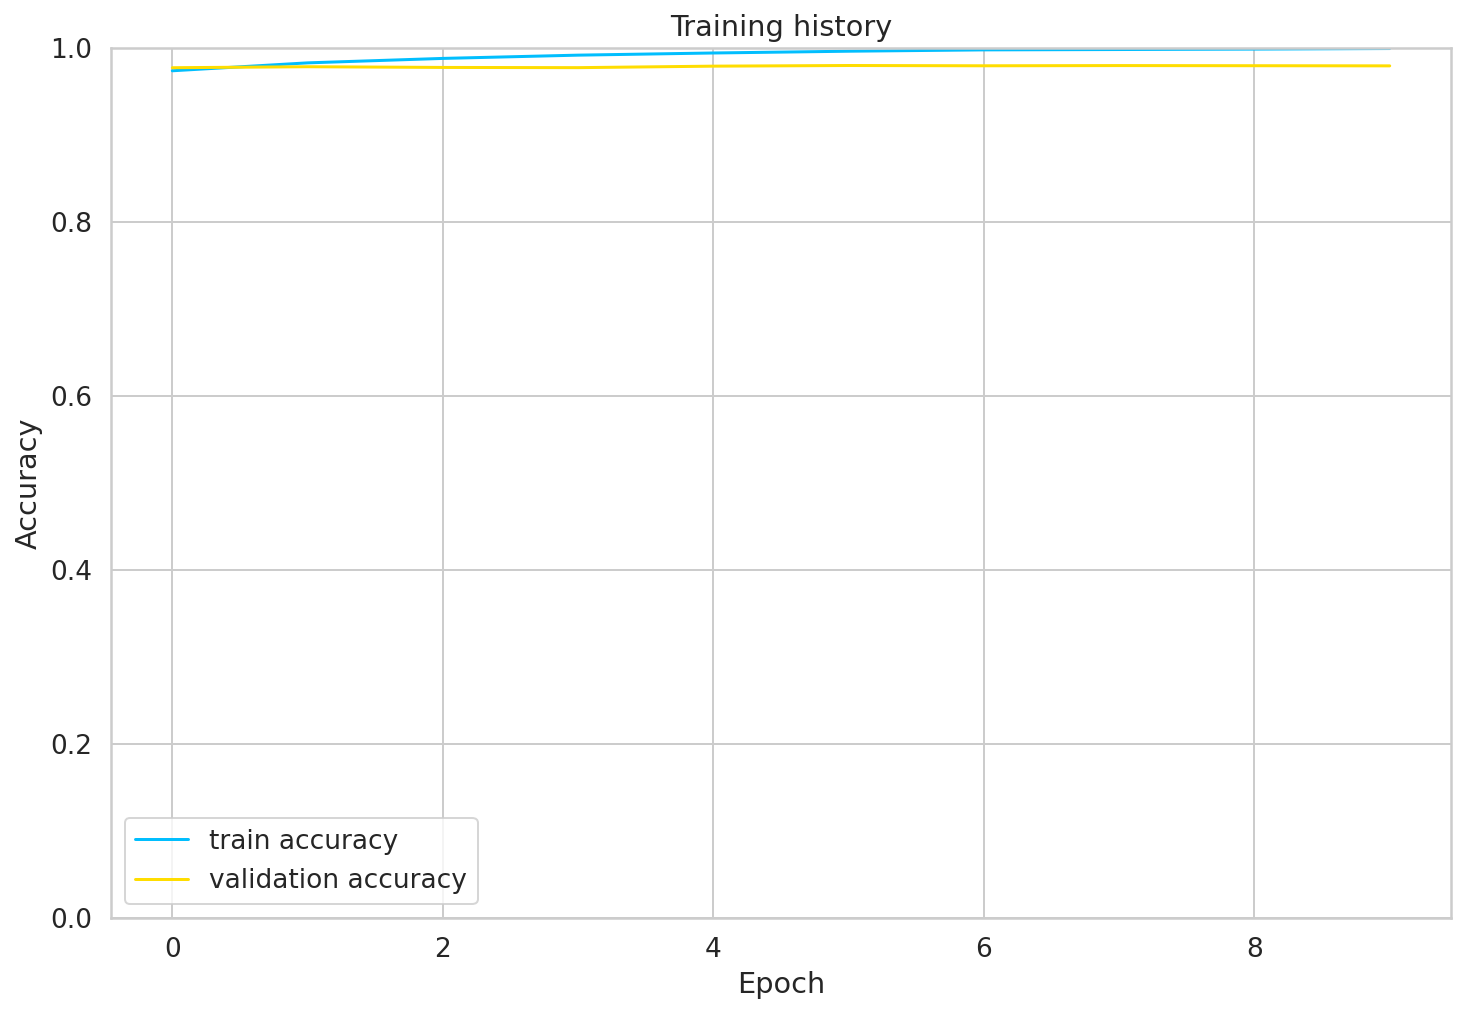

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

# Bataassss

In [ ]:
test_acc, test_loss = eval_model(
  model,
  test_data_loader,
  device,
  len(df_test)
)

print('Test Accuracy :', test_acc)
print('Test Loss :', test_loss)

Test Accuracy : 0.9790846456692913
Test Loss : 0.12379288347155343


In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            
            outputs = model(input_ids=input_ids, token_type_ids=None, attention_mask=attention_mask, labels = targets)

            loss = outputs[0]
            logits = outputs[1]
            
            _, preds = torch.max(outputs[1], dim=1)

            probs = F.softmax(outputs[1], dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.70      0.68      0.69       420
    positive       0.99      0.99      0.99     11741

    accuracy                           0.98     12161
   macro avg       0.85      0.83      0.84     12161
weighted avg       0.98      0.98      0.98     12161



In [ ]:
def predict_sentiment(text):
    review_text = text

    encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    truncation = True,
    return_token_type_ids=False,
    padding="max_length",
    return_attention_mask=True,
    return_tensors='pt',
    )

    input_ids = pad_sequences(encoded_review['input_ids'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    input_ids = input_ids.astype(dtype = 'int64')
    input_ids = torch.tensor(input_ids) 

    attention_mask = pad_sequences(encoded_review['attention_mask'], maxlen=MAX_LEN, dtype=torch.Tensor ,truncating="post",padding="post")
    attention_mask = attention_mask.astype(dtype = 'int64')
    attention_mask = torch.tensor(attention_mask) 

    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    outputs = outputs[0][0].cpu().detach()

    probs = F.softmax(outputs, dim=-1).cpu().detach().numpy().tolist()
    _, prediction = torch.max(outputs, dim =-1)

    print("Positive score:", probs[1])
    print("Negative score:", probs[0])
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_names[prediction]}')

In [ ]:
text = "Kotor dan tidak terawat,  karpet di dalam kamar jika lepas sepatu akan sangat terasa kotornya, kaki serasa berdebu, Jalan mobil menuju parkiran sangat tidak nyaman, sempit dan berliku tajam, mau keluar parkiran juga sama susahnya. tidak ada lift menuju basement parkiran, jadi jika parkir mobil akan sangat amat susah, bersusah payah naik tangga yang sempit dan agak bau, semacam tangga darurat."
predict_sentiment(text)

Positive score: 0.002845353214070201
Negative score: 0.9971545934677124
Review text: Kotor dan tidak terawat,  karpet di dalam kamar jika lepas sepatu akan sangat terasa kotornya, kaki serasa berdebu, Jalan mobil menuju parkiran sangat tidak nyaman, sempit dan berliku tajam, mau keluar parkiran juga sama susahnya. tidak ada lift menuju basement parkiran, jadi jika parkir mobil akan sangat amat susah, bersusah payah naik tangga yang sempit dan agak bau, semacam tangga darurat.
Sentiment  : negative


In [ ]:
text = "pengalaman menginap yang menyenangkan dengan konsep etnik jogja yang kental akan budaya. sarapan yang enak dan bervariasi, kamar yang luas membuat malam tahun baru kami menyenangkan walaupun hanya menonton tv."
predict_sentiment(text)

Positive score: 0.9999611377716064
Negative score: 3.886752892867662e-05
Review text: pengalaman menginap yang menyenangkan dengan konsep etnik jogja yang kental akan budaya. sarapan yang enak dan bervariasi, kamar yang luas membuat malam tahun baru kami menyenangkan walaupun hanya menonton tv.
Sentiment  : positive
